# Fashion MNIST using Custom Training Loop
 [Fashion MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)

## Imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

In [4]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='./data/', download=True, as_supervised=True )
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=False , as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling data/fashion_mnist/3.0.1.incompleteT84NWE/fashion_mnist-train.tfrecord*...:   0%|          | 0/60000…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling data/fashion_mnist/3.0.1.incompleteT84NWE/fashion_mnist-test.tfrecord*...:   0%|          | 0/10000 …

Dataset fashion_mnist downloaded and prepared to ./data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

(28, 28, 1)
()


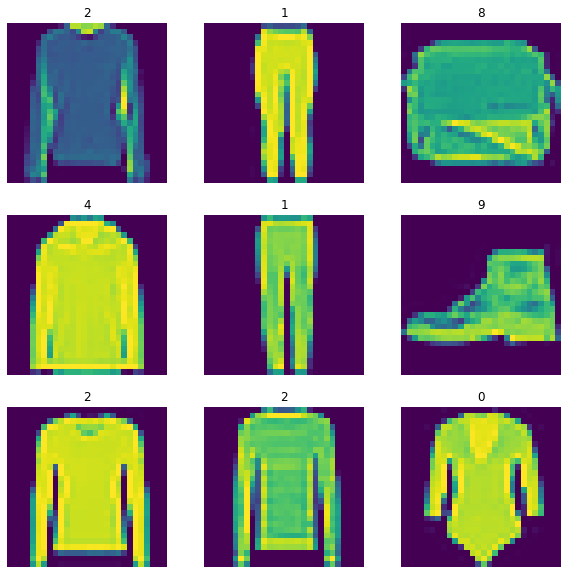

In [6]:
plt.figure(figsize=(10, 10))
i = 0
for images, labels in train_data.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    i = i + 1
    plt.title(labels.numpy().astype("uint8"))
    plt.axis("off")
    
print(images.shape)
print(labels.shape)

In [7]:
def dataset_to_numpy(ds):
    """
    Convert tensorflow dataset to numpy arrays
    """
    images = []
    labels = []

    # Iterate over a dataset
    for i, (image, label) in enumerate(tfds.as_numpy(ds)):
        images.append(image)
        labels.append(label)

    for i, img in enumerate(images):
        if i < 3:
            print(img.shape, labels[i])

    return images, labels

images, labels = dataset_to_numpy(train_data)

(28, 28, 1) 2
(28, 28, 1) 1
(28, 28, 1) 8


In [8]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [9]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='./data/fashion_mnist/3.0.1',
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kash

In [11]:
# def format_image(data):  # This function works when as_supervides = False      
#     image = data["image"]
#     image = tf.reshape(image, [-1]) # This flattens the image tensor 
#     image = tf.cast(image, 'float32')
#     image = image / 255.0
#     return image, data["label"]

In [24]:
def format_image(image, label):  
    #image, label = data
    #image = data["image"]
    image = tf.reshape(image, [-1]) # This flattens the image tensor
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, label

In [25]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [26]:
for images, labels in train_data.take(10):
    print(labels)

tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


Now you shuffle and batch your training and test datasets before feeding them to the model.

In [27]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

test =  test_data.batch(batch_size=batch_size)

In [28]:
# for step, (image, label) in enumerate(train):
#     print(image.numpy().shape)

In [29]:
for (image, label) in train.take(1):
    print(image.numpy().shape)
    print(label.numpy().shape)

(64, 784)
(64,)


## Define the Model


In [30]:
def base_model():
  inputs = tf.keras.Input(shape=(784,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

## Define Optimizer and Loss Function


In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

## Define Metrics



In [32]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

## Building Training Loop


In [33]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)
  
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  
  return logits, loss_value

In [34]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
      
      losses.append(loss_value)
      
      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

In [35]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

In [36]:

model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()




Start of epoch 0


Training loss for step 937: 0.7218: 100%|█████████▉| 937/938 


 Epoch 0: Train loss: 1.0942  Validation Loss: 0.7606, Train Accuracy: 0.6251, Validation Accuracy 0.7130
Start of epoch 1


Training loss for step 937: 0.7218: 100%|██████████| 938/938 


 Epoch 1: Train loss: 0.6625  Validation Loss: 0.6339, Train Accuracy: 0.7581, Validation Accuracy 0.7668
Start of epoch 2


Training loss for step 937: 0.5621: 100%|██████████| 938/938 
Training loss for step 937: 0.4262: 100%|█████████▉| 937/938 


 Epoch 2: Train loss: 0.5858  Validation Loss: 0.5863, Train Accuracy: 0.7877, Validation Accuracy 0.7890
Start of epoch 3


Training loss for step 937: 0.4262: 100%|██████████| 938/938 
Training loss for step 937: 0.4762: 100%|█████████▉| 937/938 


 Epoch 3: Train loss: 0.5454  Validation Loss: 0.5542, Train Accuracy: 0.8048, Validation Accuracy 0.8040
Start of epoch 4


Training loss for step 937: 0.4762: 100%|██████████| 938/938 
Training loss for step 937: 0.4762: 100%|██████████| 938/938 


 Epoch 4: Train loss: 0.5172  Validation Loss: 0.5373, Train Accuracy: 0.8166, Validation Accuracy 0.8129
Start of epoch 5


Training loss for step 937: 0.5059: 100%|██████████| 938/938 



 Epoch 5: Train loss: 0.4929  Validation Loss: 0.5116, Train Accuracy: 0.8256, Validation Accuracy 0.8211
Start of epoch 6


Training loss for step 937: 0.5496: 100%|██████████| 938/938 



 Epoch 6: Train loss: 0.4745  Validation Loss: 0.5014, Train Accuracy: 0.8324, Validation Accuracy 0.8232
Start of epoch 7


Training loss for step 937: 0.3019: 100%|██████████| 938/938 


 Epoch 7: Train loss: 0.4588  Validation Loss: 0.4889, Train Accuracy: 0.8377, Validation Accuracy 0.8263
Start of epoch 8



Training loss for step 937: 0.3674: 100%|██████████| 938/938 


 Epoch 8: Train loss: 0.4459  Validation Loss: 0.4755, Train Accuracy: 0.8422, Validation Accuracy 0.8324
Start of epoch 9



Training loss for step 937: 0.3194: 100%|█████████▉| 937/938 


 Epoch 9: Train loss: 0.4359  Validation Loss: 0.4753, Train Accuracy: 0.8459, Validation Accuracy 0.8314


## Evaluate Model

### Plots for Evaluation


Training loss for step 937: 0.3194: 100%|██████████| 938/938 


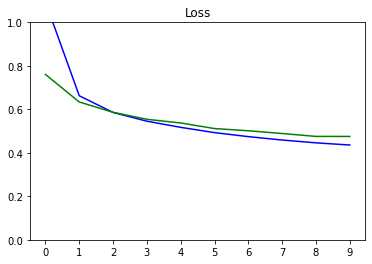

In [37]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

In [38]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

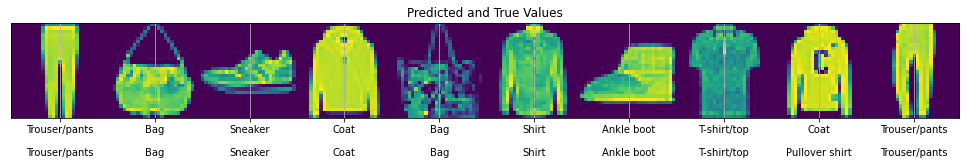

In [39]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)